# Import Package

source : https://www.kaggle.com/c/GiveMeSomeCredit <br>
by Tito Tamaro<br>
sebagai _Final Project_ JCDS Purwadhika 2020

In [1]:
import numpy as py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc, roc_auc_score, accuracy_score, balanced_accuracy_score,f1_score,recall_score,precision_score,classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
%matplotlib inline

# Functions

In [2]:
def dataframe_description(dataframe,samples=2): 
    bsDESC=[]
    for i in dataframe.columns:
        bsDESC.append([
            i, 
            dataframe[i].dtypes, 
            dataframe[i].isnull().sum(), 
            round((((dataframe[i].isnull().sum()) / (len(dataframe))) * 100),2),
            dataframe[i].nunique(), 
            dataframe[i].drop_duplicates().sample(samples).values,
            round(dataframe[i].mean(),2),
            round(dataframe[i].max(),2),
            round(dataframe[i].min(),2)
        ])
    dfDesc = pd.DataFrame(bsDESC,columns=['dataFeatures','dataType','nullValues','nullPercentage','unique','sample','mean','maxValues','minValues'])
    return dfDesc 

# Attributes Information

| Variable Name | Description | Type |
| --- | --- | --- |
|SeriousDlqin2yrs|Person experienced 90 days past due delinquency or worse|Y/N|
|RevolvingUtilizationOfUnsecuredLines|Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits|percentage|
|age|Age of borrower in years|integer|
|NumberOfTime30-59DaysPastDueNotWorse|Number of times borrower has been 30-59 days past due but no worse in the last 2 years.|integer|
|DebtRatio|Monthly debt payments| percentage|living costs divided by monthy gross income|percentage|
|MonthlyIncome|Monthly income|integer|
|NumberOfOpenCreditLinesAndLoans|Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)|integer|
|NumberOfTimes90DaysLate|Number of times borrower has been 90 days or more past due.|integer|
|NumberRealEstateLoansOrLines|Number of mortgage and real estate loans including home equity lines of credit|integer|
|NumberOfTime60-89DaysPastDueNotWorse|Number of times borrower has been 60-89 days past due but no worse in the last 2 years.|integer|
|NumberOfDependents|Number of dependents in family excluding themselves (spouse or children etc.)|integer|

Data merupakan kompetisi dari kaggle pada tahun 2011 (source: https://www.kaggle.com/c/GiveMeSomeCredit) dimana peserta diminta untuk memprediksi apakah peminjam uang akan mengalami _default_ (gagal bayar).

In [3]:
df_training = pd.read_csv('cs-training.csv')
df_training.rename(columns={'Unnamed: 0':'index'},inplace=True) # mengubah Unnamed features menjadi index
df_training = df_training.set_index('index')

df_test = pd.read_csv('cs-test.csv')
df_test.rename(columns={'Unnamed: 0':'index'},inplace=True) # mengubah Unnamed features menjadi index
df_test = df_test.set_index('index')

df_sample = pd.read_csv('sampleEntry.csv')

In [4]:
print(df_training.shape)
print(df_test.shape)
print(df_sample.shape)

(150000, 11)
(101503, 11)
(101503, 2)


## Data Description

In [5]:
dataframe_description(df_training)

,dataFeatures,dataType,nullValues,nullPercentage,unique,sample,mean,maxValues,minValues
0,SeriousDlqin2yrs,int64,0,0.00,2,"[0, 1]",0.07,1.0,0.0
1,RevolvingUtilizationOfUnsecuredLines,float64,0,0.00,125728,"[0.099040608, 0.063645565]",6.05,50708.0,0.0
2,age,int64,0,0.00,86,"[84, 28]",52.30,109.0,0.0
3,NumberOfTime30-59DaysPastDueNotWorse,int64,0,0.00,16,"[7, 3]",0.42,98.0,0.0
4,DebtRatio,float64,0,0.00,114194,"[0.328237669, 0.334769867]",353.01,329664.0,0.0
5,MonthlyIncome,float64,29731,19.82,13594,"[7893.0, 17491.0]",6670.22,3008750.0,0.0
6,NumberOfOpenCreditLinesAndLoans,int64,0,0.00,58,"[44, 0]",8.45,58.0,0.0
7,NumberOfTimes90DaysLate,int64,0,0.00,19,"[13, 5]",0.27,98.0,0.0
8,NumberRealEstateLoansOrLines,int64,0,0.00,28,"[11, 4]",1.02,54.0,0.0
9,NumberOfTime60-89DaysPastDueNotWorse,int64,0,0.00,13,"[9, 7]",0.24,98.0,0.0


Dari deskripsi di atas, features dapat dikelompokkan menjadi :

- <b>Numerical Values</b>

    - RevolvingUtilizationOfUnsecuredLines
    - age
    - NumberOfTime30-59DaysPastDueNotWorse
    - DebtRatio
    - MonthlyIncome
    - NumberOfOpenCreditLinesAndLoans
    - NumberOfTimes90DaysLate
    - NumberRealEstateLoansOrLines
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfDependents
    
    
- <b>Categorical Values</b>

    - SeriousDlqin2yrs ==> <b>Target</b>

## Data Distribution

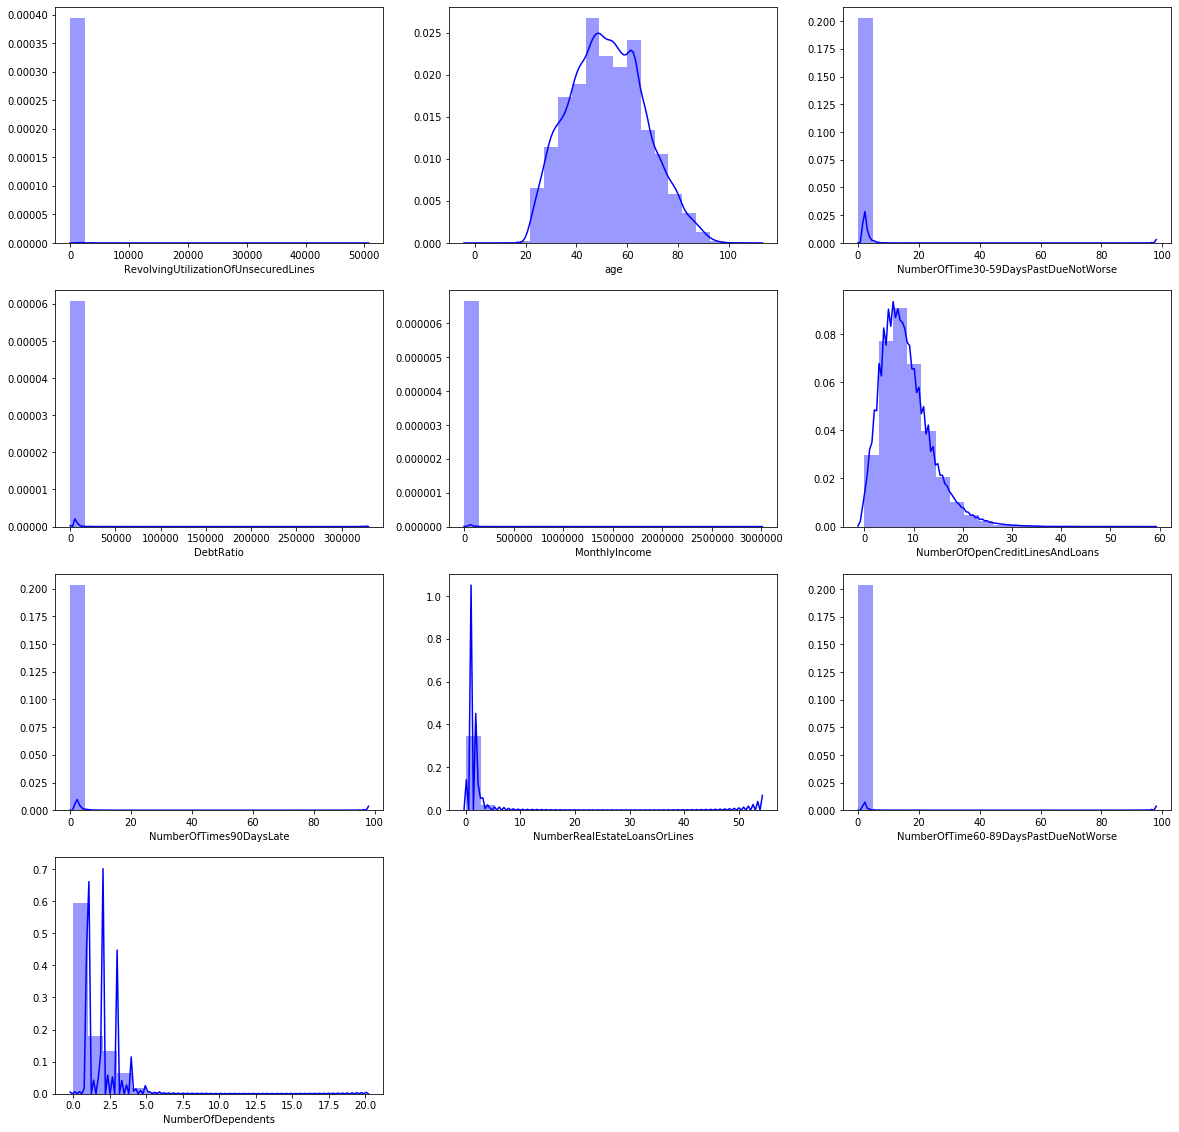

In [6]:
col = df_training.drop(['SeriousDlqin2yrs'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,11)):
    axes = fig.add_subplot(4,3,i)
    sns.distplot(df_training[j],bins=20,ax=axes, color='blue') # jumlah bins 1/10 jumlah data
plt.show()

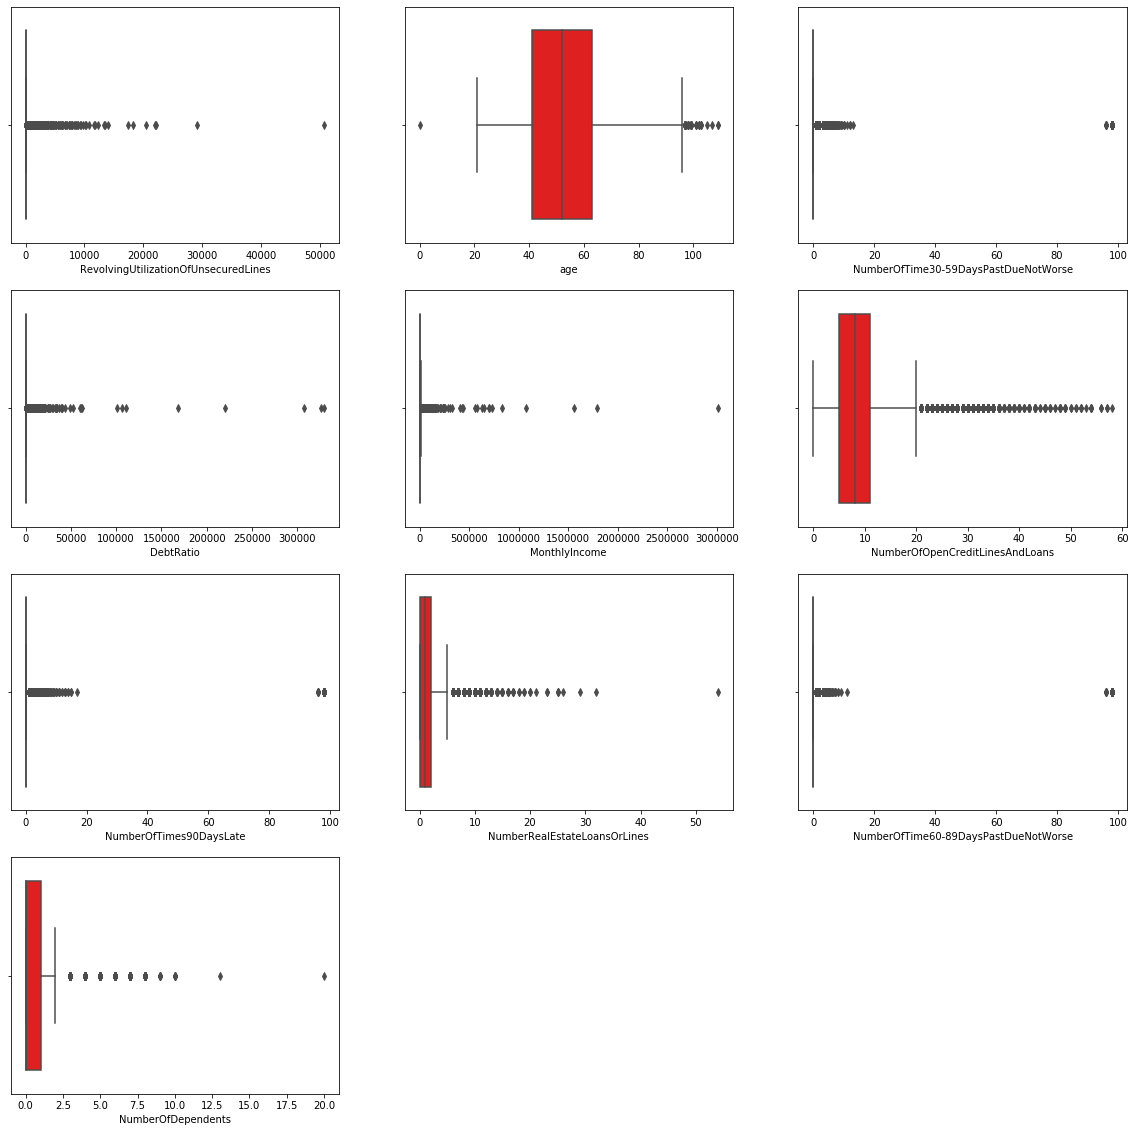

In [7]:
col = df_training.drop(['SeriousDlqin2yrs'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,11)):
    axes = fig.add_subplot(4,3,i)
    sns.boxplot(df_training[j],ax=axes, color='red')
plt.show()

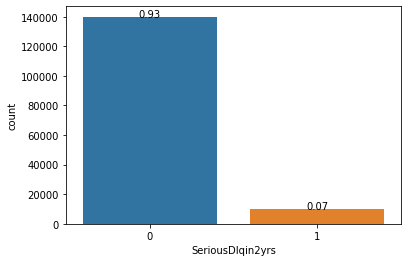

In [8]:
ax = sns.countplot(df_training['SeriousDlqin2yrs'])
total = len(df_training)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.show()

Imbalanced Target

# NaN Values

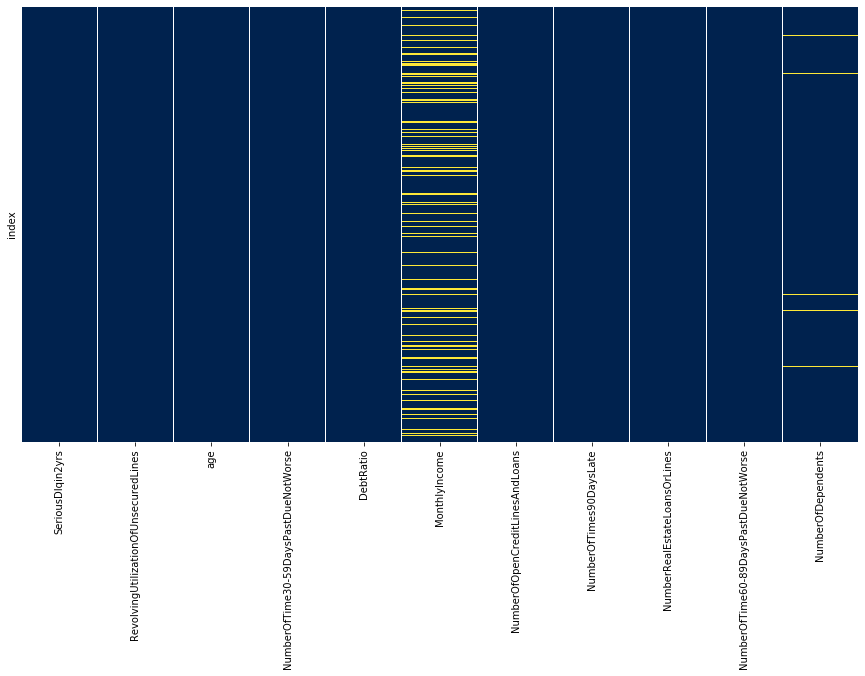

In [9]:
plt.figure(figsize=(15,8))

sns.heatmap(df_training.isna(), yticklabels=False, cmap='cividis', cbar=False)
plt.show()

In [10]:
df_training.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Sebelum dilakukan NaN values handling, akan dilakukan pengecekan terhadap data dan dilihat bagaimana pengaruhnya terhadap kolom target yaitu <b>SeriousDlqin2yrs</b>

In [11]:
df_training['nullValuesMI'] = pd.isnull(df_training['MonthlyIncome'])
df1 = pd.crosstab(index=df_training.nullValuesMI, columns=df_training.SeriousDlqin2yrs, values=df_training.nullValuesMI,aggfunc='count',normalize='all')
df1

SeriousDlqin2yrs,0,1
nullValuesMI,,
False,0.74608,0.055713
True,0.18708,0.011127


In [12]:
df_training['nullValuesND'] = pd.isnull(df_training['NumberOfDependents'])
df2 = pd.crosstab(index=df_training.nullValuesND, columns=df_training.SeriousDlqin2yrs, values=df_training.nullValuesND,aggfunc='count',normalize='all')
df2

SeriousDlqin2yrs,0,1
nullValuesND,,
False,0.908193,0.065647
True,0.024967,0.001193


## Binning Age

In [13]:
# Binning age by interval 10
bins = [-1,21,31,41,51,61,71,81,91,101,111] # binning dengan interval 10 kecuali yang pertama karena hanya ditemukan 1 data dengan age 0 (outlier)
label = ['(0-20)','(21-30)','(31-40)','(41-50)','(51-60)','(61-70)','(71-80)','(81-90)','(91-100)','(101-111)'] # label umur
df_training['binned_age']=pd.cut(df_training['age'],bins=bins,labels=label)
df_training[['age','MonthlyIncome','binned_age']].head()

,age,MonthlyIncome,binned_age
index,,,
1,45,9120.0,(41-50)
2,40,2600.0,(31-40)
3,38,3042.0,(31-40)
4,30,3300.0,(21-30)
5,49,63588.0,(41-50)


## Train Test Split

In [14]:
X = df_training.drop(columns='SeriousDlqin2yrs')
y = df_training['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X ,y ,stratify = y, train_size=.75, random_state=42) # data split

## Data Imputation

In [15]:
X_train['MonthlyIncome'] = X_train.groupby('binned_age')['MonthlyIncome'].apply(lambda x:x.fillna(x.median()))

In [16]:
X_train['NumberOfDependents'] = X_train.groupby('binned_age')['NumberOfDependents'].apply(lambda x:x.fillna(x.median()))

In [17]:
X_test['MonthlyIncome'] = X_test.groupby('binned_age')['MonthlyIncome'].apply(lambda x:x.fillna(x.median()))

In [18]:
X_test['NumberOfDependents'] = X_test.groupby('binned_age')['NumberOfDependents'].apply(lambda x:x.fillna(x.median()))

## Feature Selection

In [19]:
df_training.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'nullValuesMI', 'nullValuesND', 'binned_age'],
      dtype='object')

In [20]:
X_train.drop(['nullValuesMI','nullValuesND','binned_age'],axis=1,inplace=True)

In [21]:
X_test.drop(['nullValuesMI','nullValuesND','binned_age'],axis=1,inplace=True)

## Data Imbalanced Handling

 _<b>SMOTE</b>_

In [22]:
sm = SMOTE(random_state=42)
X_train_sm,y_train_sm=sm.fit_sample(X_train,y_train)

_<b>Oversampling<b>_

In [23]:
X = pd.concat([X_train, y_train], axis=1)

not_default = X[X.SeriousDlqin2yrs == 0]
default = X[X.SeriousDlqin2yrs == 1]

In [24]:
default_oversample = resample(default,
                            replace = True,
                            n_samples = len(not_default),
                            random_state=42
)

In [25]:
oversampled = pd.concat([not_default,default_oversample])

In [26]:
oversampled.SeriousDlqin2yrs.value_counts() # sudah sama jumlahnya

1    104980
0    104980
Name: SeriousDlqin2yrs, dtype: int64

In [27]:
X_train_os = oversampled.drop(columns='SeriousDlqin2yrs',axis=1)
y_train_os = oversampled.SeriousDlqin2yrs

_<b>Undersampling</b>_

In [28]:
X2 = pd.concat([X_train, y_train], axis=1)

not_default = X2[X2.SeriousDlqin2yrs == 0]
default = X2[X2.SeriousDlqin2yrs == 1]

In [29]:
not_default_undersample = resample(not_default,
                            replace = False,
                            n_samples = len(default),
                            random_state=42
)

In [30]:
undersampled = pd.concat([not_default_undersample,default])

In [31]:
undersampled.SeriousDlqin2yrs.value_counts() # datanya sudah dikurangi hingga jumlahnya sama

1    7520
0    7520
Name: SeriousDlqin2yrs, dtype: int64

In [32]:
X_train_us = undersampled.drop(columns='SeriousDlqin2yrs',axis=1)
y_train_us = undersampled.SeriousDlqin2yrs

## Pipeline Creation

In [33]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("logres", LogisticRegression())
])

pipeline2 = Pipeline([
    ("scaler", RobustScaler()),
    ("knc", KNeighborsClassifier())
])

pipeline3 = Pipeline([
    ("scaler", RobustScaler()),
    ("rfc", RandomForestClassifier())
])

pipeline4 = Pipeline([
    ("scaler", RobustScaler()),
    ("kxgb", XGBClassifier())
])

pipeline5 = Pipeline([
    ("scaler", StandardScaler()),
    ("logres", LogisticRegression())
])

pipeline6 = Pipeline([
    ("scaler", StandardScaler()),
    ("knc", KNeighborsClassifier())
])

pipeline7 = Pipeline([
    ("scaler", StandardScaler()),
    ("rfc", RandomForestClassifier())
])

pipeline8 = Pipeline([
    ("scaler", StandardScaler()),
    ("kxgb", XGBClassifier())
])

pipeline9 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logres", LogisticRegression())
])

pipeline10 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knc", KNeighborsClassifier())
])

pipeline11 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("rfc", RandomForestClassifier())
])

pipeline12 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("kxgb", XGBClassifier())
])

## Fitting - SMOTE

In [34]:
model1 = pipeline1.fit(X_train_sm,y_train_sm)

In [35]:
model2 = pipeline2.fit(X_train_sm,y_train_sm)

In [36]:
model3 = pipeline3.fit(X_train_sm,y_train_sm)

In [37]:
model4 = pipeline4.fit(X_train_sm,y_train_sm)

In [38]:
model5 = pipeline5.fit(X_train_sm,y_train_sm)

In [39]:
model6 = pipeline6.fit(X_train_sm,y_train_sm)

In [40]:
model7 = pipeline7.fit(X_train_sm,y_train_sm)

In [41]:
model8 = pipeline8.fit(X_train_sm,y_train_sm)

In [42]:
model9 = pipeline9.fit(X_train_sm,y_train_sm)

In [43]:
model10 = pipeline10.fit(X_train_sm,y_train_sm)

In [44]:
model11 = pipeline11.fit(X_train_sm,y_train_sm)

In [45]:
model12 = pipeline12.fit(X_train_sm,y_train_sm)

## Fitting Oversampling

In [46]:
model13 = pipeline1.fit(X_train_os,y_train_os)

In [47]:
model14 = pipeline2.fit(X_train_os,y_train_os)

In [48]:
model15 = pipeline3.fit(X_train_os,y_train_os)

In [49]:
model16 = pipeline4.fit(X_train_os,y_train_os)

In [50]:
model17 = pipeline5.fit(X_train_os,y_train_os)

In [51]:
model18 = pipeline6.fit(X_train_os,y_train_os)

In [52]:
model19 = pipeline7.fit(X_train_os,y_train_os)

In [53]:
model20 = pipeline8.fit(X_train_os,y_train_os)

In [54]:
model21 = pipeline9.fit(X_train_os,y_train_os)

In [55]:
model22 = pipeline10.fit(X_train_os,y_train_os)

In [56]:
model23 = pipeline11.fit(X_train_os,y_train_os)

In [57]:
model24 = pipeline12.fit(X_train_os,y_train_os)

## Fitting Undersampling

In [58]:
model25 = pipeline1.fit(X_train_us,y_train_us)

In [59]:
model26 = pipeline2.fit(X_train_us,y_train_us)

In [60]:
model27 = pipeline3.fit(X_train_us,y_train_us)

In [61]:
model28 = pipeline4.fit(X_train_us,y_train_us)

In [62]:
model29 = pipeline5.fit(X_train_us,y_train_us)

In [63]:
model30 = pipeline6.fit(X_train_us,y_train_us)

In [64]:
model31 = pipeline7.fit(X_train_us,y_train_us)

In [65]:
model32 = pipeline8.fit(X_train_us,y_train_us)

In [66]:
model33 = pipeline9.fit(X_train_us,y_train_us)

In [67]:
model34 = pipeline10.fit(X_train_us,y_train_us)

In [68]:
model35 = pipeline11.fit(X_train_us,y_train_us)

In [69]:
model36 = pipeline12.fit(X_train_us,y_train_us)

## ROC-AUC Curve

In [70]:
proba1 = model1.predict_proba(X_test)
proba2 = model2.predict_proba(X_test)
proba3 = model3.predict_proba(X_test)
proba4 = model4.predict_proba(X_test)
proba5 = model5.predict_proba(X_test)
proba6 = model6.predict_proba(X_test)
proba7 = model7.predict_proba(X_test)
proba8 = model8.predict_proba(X_test)
proba9 = model9.predict_proba(X_test)
proba10 = model10.predict_proba(X_test)
proba11 = model11.predict_proba(X_test)
proba12 = model12.predict_proba(X_test)
proba13 = model13.predict_proba(X_test)
proba14 = model14.predict_proba(X_test)
proba15 = model15.predict_proba(X_test)
proba16 = model16.predict_proba(X_test)
proba17 = model17.predict_proba(X_test)
proba18 = model18.predict_proba(X_test)
proba19 = model19.predict_proba(X_test)
proba20 = model20.predict_proba(X_test)
proba21 = model21.predict_proba(X_test)
proba22 = model22.predict_proba(X_test)
proba23 = model23.predict_proba(X_test)
proba24 = model24.predict_proba(X_test)
proba25 = model25.predict_proba(X_test)
proba26 = model26.predict_proba(X_test)
proba27 = model27.predict_proba(X_test)
proba28 = model28.predict_proba(X_test)
proba29 = model29.predict_proba(X_test)
proba30 = model30.predict_proba(X_test)
proba31 = model31.predict_proba(X_test)
proba32 = model32.predict_proba(X_test)
proba33 = model33.predict_proba(X_test)
proba34 = model34.predict_proba(X_test)
proba35 = model35.predict_proba(X_test)
proba36 = model36.predict_proba(X_test)

In [71]:
# Performa Test
prediksi1 = model1.predict(X_test)
prediksi2 = model2.predict(X_test)
prediksi3 = model3.predict(X_test)
prediksi4 = model4.predict(X_test)
prediksi5 = model5.predict(X_test)
prediksi6 = model6.predict(X_test)
prediksi7 = model7.predict(X_test)
prediksi8 = model8.predict(X_test)
prediksi9 = model9.predict(X_test)
prediksi10 = model10.predict(X_test)
prediksi11 = model11.predict(X_test)
prediksi12 = model12.predict(X_test)
prediksi13 = model13.predict(X_test)
prediksi14 = model14.predict(X_test)
prediksi15 = model15.predict(X_test)
prediksi16 = model16.predict(X_test)
prediksi17 = model17.predict(X_test)
prediksi18 = model18.predict(X_test)
prediksi19 = model19.predict(X_test)
prediksi20 = model20.predict(X_test)
prediksi21 = model21.predict(X_test)
prediksi22 = model22.predict(X_test)
prediksi23 = model23.predict(X_test)
prediksi24 = model24.predict(X_test)
prediksi25 = model25.predict(X_test)
prediksi26 = model26.predict(X_test)
prediksi27 = model27.predict(X_test)
prediksi28 = model28.predict(X_test)
prediksi29 = model29.predict(X_test)
prediksi30 = model30.predict(X_test)
prediksi31 = model31.predict(X_test)
prediksi32 = model32.predict(X_test)
prediksi33 = model33.predict(X_test)
prediksi34 = model34.predict(X_test)
prediksi35 = model35.predict(X_test)
prediksi36 = model36.predict(X_test)

# Performa Training
prediksi_train1 = model1.predict(X_train_sm)
prediksi_train2 = model2.predict(X_train_sm)
prediksi_train3 = model3.predict(X_train_sm)
prediksi_train4 = model4.predict(X_train_sm)
prediksi_train5 = model5.predict(X_train_sm)
prediksi_train6 = model6.predict(X_train_sm)
prediksi_train7 = model7.predict(X_train_sm)
prediksi_train8 = model8.predict(X_train_sm)
prediksi_train9 = model9.predict(X_train_sm)
prediksi_train10 = model10.predict(X_train_sm)
prediksi_train11 = model11.predict(X_train_sm)
prediksi_train12 = model12.predict(X_train_sm)
prediksi_train13 = model13.predict(X_train_os)
prediksi_train14 = model14.predict(X_train_os)
prediksi_train15 = model15.predict(X_train_os)
prediksi_train16 = model16.predict(X_train_os)
prediksi_train17 = model17.predict(X_train_os)
prediksi_train18 = model18.predict(X_train_os)
prediksi_train19 = model19.predict(X_train_os)
prediksi_train20 = model20.predict(X_train_os)
prediksi_train21 = model21.predict(X_train_os)
prediksi_train22 = model22.predict(X_train_os)
prediksi_train23 = model23.predict(X_train_os)
prediksi_train24 = model24.predict(X_train_os)
prediksi_train25 = model25.predict(X_train_us)
prediksi_train26 = model26.predict(X_train_us)
prediksi_train27 = model27.predict(X_train_us)
prediksi_train28 = model28.predict(X_train_us)
prediksi_train29 = model29.predict(X_train_us)
prediksi_train30 = model30.predict(X_train_us)
prediksi_train31 = model31.predict(X_train_us)
prediksi_train32 = model32.predict(X_train_us)
prediksi_train33 = model33.predict(X_train_us)
prediksi_train34 = model34.predict(X_train_us)
prediksi_train35 = model35.predict(X_train_us)
prediksi_train36 = model36.predict(X_train_us)

In [72]:
# Perbandingan akurasi test dan train 

akurasi_train1 = accuracy_score(y_test,prediksi1)
akurasi_train2 = accuracy_score(y_test,prediksi2)
akurasi_train3 = accuracy_score(y_test,prediksi3)
akurasi_train4 = accuracy_score(y_test,prediksi4)
akurasi_train5 = accuracy_score(y_test,prediksi5)
akurasi_train6 = accuracy_score(y_test,prediksi6)
akurasi_train7 = accuracy_score(y_test,prediksi7)
akurasi_train8 = accuracy_score(y_test,prediksi8)
akurasi_train9 = accuracy_score(y_test,prediksi9)
akurasi_train10 = accuracy_score(y_test,prediksi10)
akurasi_train11 = accuracy_score(y_test,prediksi11)
akurasi_train12 = accuracy_score(y_test,prediksi12)
akurasi_train13 = accuracy_score(y_test,prediksi13)
akurasi_train14 = accuracy_score(y_test,prediksi14)
akurasi_train15 = accuracy_score(y_test,prediksi15)
akurasi_train16 = accuracy_score(y_test,prediksi16)
akurasi_train17 = accuracy_score(y_test,prediksi17)
akurasi_train18 = accuracy_score(y_test,prediksi18)
akurasi_train19 = accuracy_score(y_test,prediksi19)
akurasi_train20 = accuracy_score(y_test,prediksi20)
akurasi_train21 = accuracy_score(y_test,prediksi21)
akurasi_train22 = accuracy_score(y_test,prediksi22)
akurasi_train23 = accuracy_score(y_test,prediksi23)
akurasi_train24 = accuracy_score(y_test,prediksi24)
akurasi_train25 = accuracy_score(y_test,prediksi25)
akurasi_train26 = accuracy_score(y_test,prediksi26)
akurasi_train27 = accuracy_score(y_test,prediksi27)
akurasi_train28 = accuracy_score(y_test,prediksi28)
akurasi_train29 = accuracy_score(y_test,prediksi29)
akurasi_train30 = accuracy_score(y_test,prediksi30)
akurasi_train31 = accuracy_score(y_test,prediksi31)
akurasi_train32 = accuracy_score(y_test,prediksi32)
akurasi_train33 = accuracy_score(y_test,prediksi33)
akurasi_train34 = accuracy_score(y_test,prediksi34)
akurasi_train35 = accuracy_score(y_test,prediksi35)
akurasi_train36 = accuracy_score(y_test,prediksi36)

In [73]:
# Confusion Matrix

TN1,FP1,FN1,TP1 = confusion_matrix(y_test,prediksi1)[0,0],confusion_matrix(y_test,prediksi1)[0,1],confusion_matrix(y_test,prediksi1)[1,0],confusion_matrix(y_test,prediksi1)[1,1]
TN2,FP2,FN2,TP2 = confusion_matrix(y_test,prediksi2)[0,0],confusion_matrix(y_test,prediksi2)[0,1],confusion_matrix(y_test,prediksi2)[1,0],confusion_matrix(y_test,prediksi2)[1,1]
TN3,FP3,FN3,TP3 = confusion_matrix(y_test,prediksi3)[0,0],confusion_matrix(y_test,prediksi3)[0,1],confusion_matrix(y_test,prediksi3)[1,0],confusion_matrix(y_test,prediksi3)[1,1]
TN4,FP4,FN4,TP4 = confusion_matrix(y_test,prediksi4)[0,0],confusion_matrix(y_test,prediksi4)[0,1],confusion_matrix(y_test,prediksi4)[1,0],confusion_matrix(y_test,prediksi4)[1,1]
TN5,FP5,FN5,TP5 = confusion_matrix(y_test,prediksi5)[0,0],confusion_matrix(y_test,prediksi5)[0,1],confusion_matrix(y_test,prediksi5)[1,0],confusion_matrix(y_test,prediksi5)[1,1]
TN6,FP6,FN6,TP6 = confusion_matrix(y_test,prediksi6)[0,0],confusion_matrix(y_test,prediksi6)[0,1],confusion_matrix(y_test,prediksi6)[1,0],confusion_matrix(y_test,prediksi6)[1,1]
TN7,FP7,FN7,TP7 = confusion_matrix(y_test,prediksi7)[0,0],confusion_matrix(y_test,prediksi7)[0,1],confusion_matrix(y_test,prediksi7)[1,0],confusion_matrix(y_test,prediksi7)[1,1]
TN8,FP8,FN8,TP8 = confusion_matrix(y_test,prediksi8)[0,0],confusion_matrix(y_test,prediksi8)[0,1],confusion_matrix(y_test,prediksi8)[1,0],confusion_matrix(y_test,prediksi8)[1,1]
TN9,FP9,FN9,TP9 = confusion_matrix(y_test,prediksi9)[0,0],confusion_matrix(y_test,prediksi9)[0,1],confusion_matrix(y_test,prediksi9)[1,0],confusion_matrix(y_test,prediksi9)[1,1]
TN10,FP10,FN10,TP10 = confusion_matrix(y_test,prediksi10)[0,0],confusion_matrix(y_test,prediksi10)[0,1],confusion_matrix(y_test,prediksi10)[1,0],confusion_matrix(y_test,prediksi10)[1,1]
TN11,FP11,FN11,TP11 = confusion_matrix(y_test,prediksi11)[0,0],confusion_matrix(y_test,prediksi11)[0,1],confusion_matrix(y_test,prediksi11)[1,0],confusion_matrix(y_test,prediksi11)[1,1]
TN12,FP12,FN12,TP12 = confusion_matrix(y_test,prediksi12)[0,0],confusion_matrix(y_test,prediksi12)[0,1],confusion_matrix(y_test,prediksi12)[1,0],confusion_matrix(y_test,prediksi12)[1,1]
TN13,FP13,FN13,TP13 = confusion_matrix(y_test,prediksi13)[0,0],confusion_matrix(y_test,prediksi13)[0,1],confusion_matrix(y_test,prediksi13)[1,0],confusion_matrix(y_test,prediksi13)[1,1]
TN14,FP14,FN14,TP14 = confusion_matrix(y_test,prediksi14)[0,0],confusion_matrix(y_test,prediksi14)[0,1],confusion_matrix(y_test,prediksi14)[1,0],confusion_matrix(y_test,prediksi14)[1,1]
TN15,FP15,FN15,TP15 = confusion_matrix(y_test,prediksi15)[0,0],confusion_matrix(y_test,prediksi15)[0,1],confusion_matrix(y_test,prediksi15)[1,0],confusion_matrix(y_test,prediksi15)[1,1]
TN16,FP16,FN16,TP16 = confusion_matrix(y_test,prediksi16)[0,0],confusion_matrix(y_test,prediksi16)[0,1],confusion_matrix(y_test,prediksi16)[1,0],confusion_matrix(y_test,prediksi16)[1,1]
TN17,FP17,FN17,TP17 = confusion_matrix(y_test,prediksi17)[0,0],confusion_matrix(y_test,prediksi17)[0,1],confusion_matrix(y_test,prediksi17)[1,0],confusion_matrix(y_test,prediksi17)[1,1]
TN18,FP18,FN18,TP18 = confusion_matrix(y_test,prediksi18)[0,0],confusion_matrix(y_test,prediksi18)[0,1],confusion_matrix(y_test,prediksi18)[1,0],confusion_matrix(y_test,prediksi18)[1,1]
TN19,FP19,FN19,TP19 = confusion_matrix(y_test,prediksi19)[0,0],confusion_matrix(y_test,prediksi19)[0,1],confusion_matrix(y_test,prediksi19)[1,0],confusion_matrix(y_test,prediksi19)[1,1]
TN20,FP20,FN20,TP20 = confusion_matrix(y_test,prediksi20)[0,0],confusion_matrix(y_test,prediksi20)[0,1],confusion_matrix(y_test,prediksi20)[1,0],confusion_matrix(y_test,prediksi20)[1,1]
TN21,FP21,FN21,TP21 = confusion_matrix(y_test,prediksi21)[0,0],confusion_matrix(y_test,prediksi21)[0,1],confusion_matrix(y_test,prediksi21)[1,0],confusion_matrix(y_test,prediksi21)[1,1]
TN22,FP22,FN22,TP22 = confusion_matrix(y_test,prediksi22)[0,0],confusion_matrix(y_test,prediksi22)[0,1],confusion_matrix(y_test,prediksi22)[1,0],confusion_matrix(y_test,prediksi22)[1,1]
TN23,FP23,FN23,TP23 = confusion_matrix(y_test,prediksi23)[0,0],confusion_matrix(y_test,prediksi23)[0,1],confusion_matrix(y_test,prediksi23)[1,0],confusion_matrix(y_test,prediksi23)[1,1]
TN24,FP24,FN24,TP24 = confusion_matrix(y_test,prediksi24)[0,0],confusion_matrix(y_test,prediksi24)[0,1],confusion_matrix(y_test,prediksi24)[1,0],confusion_matrix(y_test,prediksi24)[1,1]
TN25,FP25,FN25,TP25 = confusion_matrix(y_test,prediksi25)[0,0],confusion_matrix(y_test,prediksi25)[0,1],confusion_matrix(y_test,prediksi25)[1,0],confusion_matrix(y_test,prediksi25)[1,1]
TN26,FP26,FN26,TP26 = confusion_matrix(y_test,prediksi26)[0,0],confusion_matrix(y_test,prediksi26)[0,1],confusion_matrix(y_test,prediksi26)[1,0],confusion_matrix(y_test,prediksi26)[1,1]
TN27,FP27,FN27,TP27 = confusion_matrix(y_test,prediksi27)[0,0],confusion_matrix(y_test,prediksi27)[0,1],confusion_matrix(y_test,prediksi27)[1,0],confusion_matrix(y_test,prediksi27)[1,1]
TN28,FP28,FN28,TP28 = confusion_matrix(y_test,prediksi28)[0,0],confusion_matrix(y_test,prediksi28)[0,1],confusion_matrix(y_test,prediksi28)[1,0],confusion_matrix(y_test,prediksi28)[1,1]
TN29,FP29,FN29,TP29 = confusion_matrix(y_test,prediksi29)[0,0],confusion_matrix(y_test,prediksi29)[0,1],confusion_matrix(y_test,prediksi29)[1,0],confusion_matrix(y_test,prediksi29)[1,1]
TN30,FP30,FN30,TP30 = confusion_matrix(y_test,prediksi30)[0,0],confusion_matrix(y_test,prediksi30)[0,1],confusion_matrix(y_test,prediksi30)[1,0],confusion_matrix(y_test,prediksi30)[1,1]
TN31,FP31,FN31,TP31 = confusion_matrix(y_test,prediksi31)[0,0],confusion_matrix(y_test,prediksi31)[0,1],confusion_matrix(y_test,prediksi31)[1,0],confusion_matrix(y_test,prediksi31)[1,1]
TN32,FP32,FN32,TP32 = confusion_matrix(y_test,prediksi32)[0,0],confusion_matrix(y_test,prediksi32)[0,1],confusion_matrix(y_test,prediksi32)[1,0],confusion_matrix(y_test,prediksi32)[1,1]
TN33,FP33,FN33,TP33 = confusion_matrix(y_test,prediksi33)[0,0],confusion_matrix(y_test,prediksi33)[0,1],confusion_matrix(y_test,prediksi33)[1,0],confusion_matrix(y_test,prediksi33)[1,1]
TN34,FP34,FN34,TP34 = confusion_matrix(y_test,prediksi34)[0,0],confusion_matrix(y_test,prediksi34)[0,1],confusion_matrix(y_test,prediksi34)[1,0],confusion_matrix(y_test,prediksi34)[1,1]
TN35,FP35,FN35,TP35 = confusion_matrix(y_test,prediksi35)[0,0],confusion_matrix(y_test,prediksi35)[0,1],confusion_matrix(y_test,prediksi35)[1,0],confusion_matrix(y_test,prediksi35)[1,1]
TN36,FP36,FN36,TP36 = confusion_matrix(y_test,prediksi36)[0,0],confusion_matrix(y_test,prediksi36)[0,1],confusion_matrix(y_test,prediksi36)[1,0],confusion_matrix(y_test,prediksi36)[1,1]


In [74]:
pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

pred2 = proba2[:,1] 
fpr2, tpr2, threshold2 = roc_curve(y_test, pred2)

pred3 = proba3[:,1] 
fpr3, tpr3, threshold3 = roc_curve(y_test, pred3)

pred4 = proba4[:,1] 
fpr4, tpr4, threshold4 = roc_curve(y_test, pred4)

pred5 = proba5[:,1] 
fpr5, tpr5, threshold5 = roc_curve(y_test, pred5)

pred6 = proba6[:,1] 
fpr6, tpr6, threshold6 = roc_curve(y_test, pred6)

pred7 = proba7[:,1] 
fpr7, tpr7, threshold7 = roc_curve(y_test, pred7)

pred8 = proba8[:,1] 
fpr8, tpr8, threshold8 = roc_curve(y_test, pred8)

pred9 = proba9[:,1] 
fpr9, tpr9, threshold9 = roc_curve(y_test, pred9)

pred10 = proba10[:,1] 
fpr10, tpr10, threshold10 = roc_curve(y_test, pred10)

pred11 = proba11[:,1] 
fpr11, tpr11, threshold11 = roc_curve(y_test, pred11)

pred12 = proba12[:,1] 
fpr12, tpr12, threshold12 = roc_curve(y_test, pred12)

pred13 = proba13[:,1] 
fpr13, tpr13, threshold13 = roc_curve(y_test, pred13)

pred14 = proba14[:,1] 
fpr14, tpr14, threshold14 = roc_curve(y_test, pred14)

pred15 = proba15[:,1] 
fpr15, tpr15, threshold15 = roc_curve(y_test, pred15)

pred16 = proba16[:,1] 
fpr16, tpr16, threshold16 = roc_curve(y_test, pred16)

pred17 = proba17[:,1] 
fpr17, tpr17, threshold17 = roc_curve(y_test, pred17)

pred18 = proba18[:,1] 
fpr18, tpr18, threshold18 = roc_curve(y_test, pred18)

pred19 = proba19[:,1] 
fpr19, tpr19, threshold19 = roc_curve(y_test, pred19)

pred20 = proba20[:,1] 
fpr20, tpr20, threshold20 = roc_curve(y_test, pred20)

pred21 = proba21[:,1] 
fpr21, tpr21, threshold21 = roc_curve(y_test, pred21)

pred22 = proba22[:,1] 
fpr22, tpr22, threshold22 = roc_curve(y_test, pred22)

pred23 = proba23[:,1] 
fpr23, tpr23, threshold23 = roc_curve(y_test, pred23)

pred24 = proba24[:,1] 
fpr24, tpr24, threshold24 = roc_curve(y_test, pred24)

pred25 = proba25[:,1] 
fpr25, tpr25, threshold25 = roc_curve(y_test, pred25)

pred26 = proba26[:,1] 
fpr26, tpr26, threshold26 = roc_curve(y_test, pred26)

pred27 = proba27[:,1] 
fpr27, tpr27, threshold27 = roc_curve(y_test, pred27)

pred28 = proba28[:,1] 
fpr28, tpr28, threshold28 = roc_curve(y_test, pred28)

pred29 = proba29[:,1] 
fpr29, tpr29, threshold29 = roc_curve(y_test, pred29)

pred30 = proba30[:,1] 
fpr30, tpr30, threshold30 = roc_curve(y_test, pred30)

pred31 = proba31[:,1] 
fpr31, tpr31, threshold31 = roc_curve(y_test, pred31)

pred32 = proba32[:,1] 
fpr32, tpr32, threshold32 = roc_curve(y_test, pred32)

pred33 = proba33[:,1] 
fpr33, tpr33, threshold33 = roc_curve(y_test, pred33)

pred34 = proba34[:,1] 
fpr34, tpr34, threshold34 = roc_curve(y_test, pred34)

pred35 = proba35[:,1] 
fpr35, tpr35, threshold35 = roc_curve(y_test, pred35)

pred36 = proba36[:,1] 
fpr36, tpr36, threshold36 = roc_curve(y_test, pred36)

In [75]:
sc1 = round(auc(fpr1,tpr1),3)
sc2 = round(auc(fpr2,tpr2),3)
sc3 = round(auc(fpr3,tpr3),3)
sc4 = round(auc(fpr4,tpr4),3)
sc5 = round(auc(fpr5,tpr5),3)
sc6 = round(auc(fpr6,tpr6),3)
sc7 = round(auc(fpr7,tpr7),3)
sc8 = round(auc(fpr8,tpr8),3)
sc9 = round(auc(fpr9,tpr9),3)
sc10 = round(auc(fpr10,tpr10),3)
sc11 = round(auc(fpr11,tpr11),3)
sc12 = round(auc(fpr12,tpr12),3)
sc13 = round(auc(fpr13,tpr13),3)
sc14 = round(auc(fpr14,tpr14),3)
sc15 = round(auc(fpr15,tpr15),3)
sc16 = round(auc(fpr16,tpr16),3)
sc17 = round(auc(fpr17,tpr17),3)
sc18 = round(auc(fpr18,tpr18),3)
sc19 = round(auc(fpr19,tpr19),3)
sc20 = round(auc(fpr20,tpr20),3)
sc21 = round(auc(fpr21,tpr21),3)
sc22 = round(auc(fpr22,tpr22),3)
sc23 = round(auc(fpr23,tpr23),3)
sc24 = round(auc(fpr24,tpr24),3)
sc25 = round(auc(fpr25,tpr25),3)
sc26 = round(auc(fpr26,tpr26),3)
sc27 = round(auc(fpr27,tpr27),3)
sc28 = round(auc(fpr28,tpr28),3)
sc29 = round(auc(fpr29,tpr29),3)
sc30 = round(auc(fpr30,tpr30),3)
sc31 = round(auc(fpr31,tpr31),3)
sc32 = round(auc(fpr32,tpr32),3)
sc33 = round(auc(fpr33,tpr33),3)
sc34 = round(auc(fpr34,tpr34),3)
sc35 = round(auc(fpr35,tpr35),3)
sc36 = round(auc(fpr36,tpr36),3)

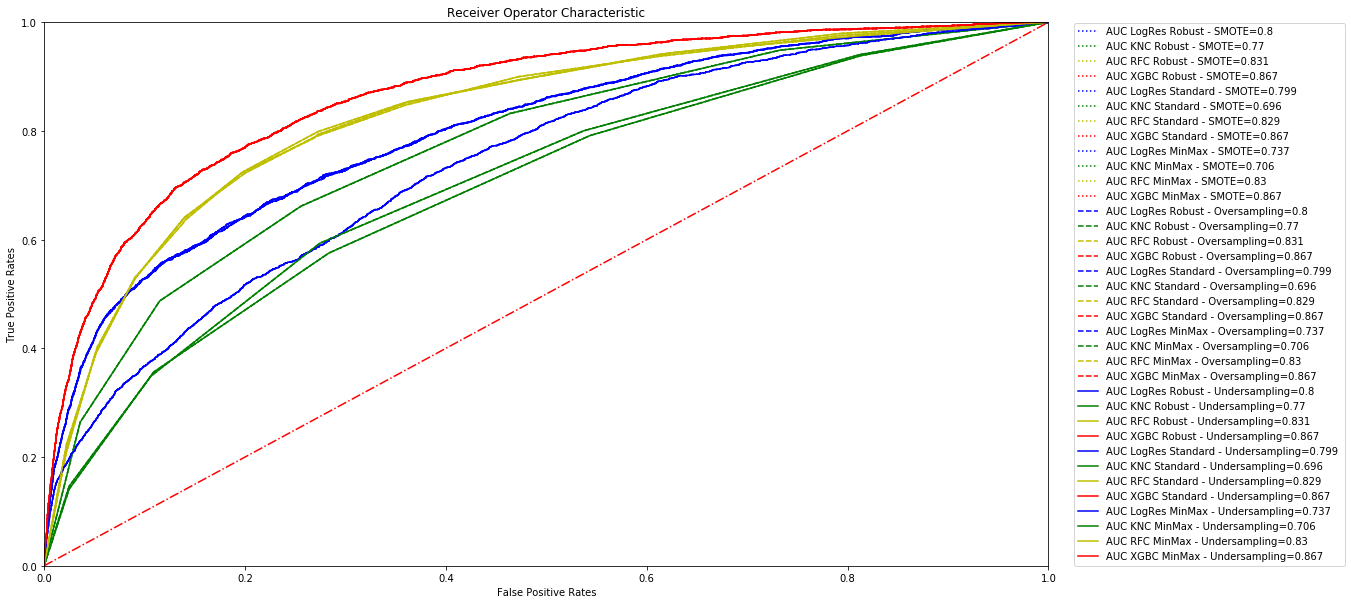

In [76]:
plt.figure(figsize=(18,10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC LogRes Robust - SMOTE={sc1} ')
plt.plot(fpr2, tpr2, 'g:', label=f'AUC KNC Robust - SMOTE={sc2} ')
plt.plot(fpr3, tpr3, 'y:', label=f'AUC RFC Robust - SMOTE={sc3} ')
plt.plot(fpr4, tpr4, 'r:', label=f'AUC XGBC Robust - SMOTE={sc4} ')
plt.plot(fpr5, tpr5, 'b:', label=f'AUC LogRes Standard - SMOTE={sc5} ')
plt.plot(fpr6, tpr6, 'g:', label=f'AUC KNC Standard - SMOTE={sc6} ')
plt.plot(fpr7, tpr7, 'y:', label=f'AUC RFC Standard - SMOTE={sc7} ')
plt.plot(fpr8, tpr8, 'r:', label=f'AUC XGBC Standard - SMOTE={sc8} ')
plt.plot(fpr9, tpr9, 'b:', label=f'AUC LogRes MinMax - SMOTE={sc9} ')
plt.plot(fpr10, tpr10, 'g:', label=f'AUC KNC MinMax - SMOTE={sc10} ')
plt.plot(fpr11, tpr11, 'y:', label=f'AUC RFC MinMax - SMOTE={sc11} ')
plt.plot(fpr12, tpr12, 'r:', label=f'AUC XGBC MinMax - SMOTE={sc12} ')
plt.plot(fpr13, tpr13, 'b--', label=f'AUC LogRes Robust - Oversampling={sc13} ')
plt.plot(fpr14, tpr14, 'g--', label=f'AUC KNC Robust - Oversampling={sc14} ')
plt.plot(fpr15, tpr15, 'y--', label=f'AUC RFC Robust - Oversampling={sc15} ')
plt.plot(fpr16, tpr16, 'r--', label=f'AUC XGBC Robust - Oversampling={sc16} ')
plt.plot(fpr17, tpr17, 'b--', label=f'AUC LogRes Standard - Oversampling={sc17} ')
plt.plot(fpr18, tpr18, 'g--', label=f'AUC KNC Standard - Oversampling={sc18} ')
plt.plot(fpr19, tpr19, 'y--', label=f'AUC RFC Standard - Oversampling={sc19} ')
plt.plot(fpr20, tpr20, 'r--', label=f'AUC XGBC Standard - Oversampling={sc20} ')
plt.plot(fpr21, tpr21, 'b--', label=f'AUC LogRes MinMax - Oversampling={sc21} ')
plt.plot(fpr22, tpr22, 'g--', label=f'AUC KNC MinMax - Oversampling={sc22} ')
plt.plot(fpr23, tpr23, 'y--', label=f'AUC RFC MinMax - Oversampling={sc23} ')
plt.plot(fpr24, tpr24, 'r--', label=f'AUC XGBC MinMax - Oversampling={sc24} ')
plt.plot(fpr25, tpr25, 'b', label=f'AUC LogRes Robust - Undersampling={sc25} ')
plt.plot(fpr26, tpr26, 'g', label=f'AUC KNC Robust - Undersampling={sc26} ')
plt.plot(fpr27, tpr27, 'y', label=f'AUC RFC Robust - Undersampling={sc27} ')
plt.plot(fpr28, tpr28, 'r', label=f'AUC XGBC Robust - Undersampling={sc28} ')
plt.plot(fpr29, tpr29, 'b', label=f'AUC LogRes Standard - Undersampling={sc29} ')
plt.plot(fpr30, tpr30, 'g', label=f'AUC KNC Standard - Undersampling={sc30} ')
plt.plot(fpr31, tpr31, 'y', label=f'AUC RFC Standard - Undersampling={sc31} ')
plt.plot(fpr32, tpr32, 'r', label=f'AUC XGBC Standard - Undersampling={sc32} ')
plt.plot(fpr33, tpr33, 'b', label=f'AUC LogRes MinMax - Undersampling={sc33} ')
plt.plot(fpr34, tpr34, 'g', label=f'AUC KNC MinMax - Undersampling={sc34} ')
plt.plot(fpr35, tpr35, 'y', label=f'AUC RFC MinMax - Undersampling={sc35} ')
plt.plot(fpr36, tpr36, 'r', label=f'AUC XGBC MinMax - Undersampling={sc36} ')


plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend(bbox_to_anchor=(0.3,0.,1,1),loc=5)
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [77]:
list_of_sc=[sc1,sc2,sc3,sc4,sc5,sc6,sc7,sc8,sc9,sc10,sc11,sc12,sc13,sc14,sc15,sc16,sc17,sc18,sc19,sc20,sc21,sc22,sc23,sc24,sc25,sc26,sc27,sc28,sc29,sc30,sc31,sc32,sc33,sc34,sc35,sc36]

In [78]:
list_of_algo=[
    'AUC LogRes Robust - SMOTE','AUC KNC Robust - SMOTE','AUC RFC Robust - SMOTE','AUC XGBC Robust - SMOTE','AUC LogRes Standard - SMOTE','AUC KNC Standard - SMOTE','AUC RFC Standard - SMOTE','AUC XGBC Standard - SMOTE','AUC LogRes MinMax - SMOTE','AUC KNC MinMax - SMOTE','AUC RFC MinMax - SMOTE','AUC XGBC MinMax - SMOTE',
    'AUC LogRes Robust - Oversampling','AUC KNC Robust - Oversampling','AUC RFC Robust - Oversampling','AUC XGBC Robust - Oversampling','AUC LogRes Standard - Oversampling','AUC KNC Standard - Oversampling','AUC RFC Standard - Oversampling','AUC XGBC Standard - Oversampling','AUC LogRes MinMax - Oversampling','AUC KNC MinMax - Oversampling','AUC RFC MinMax - Oversampling','AUC XGBC MinMax - Oversampling',
    'AUC LogRes Robust - Undersampling','AUC KNC Robust - Undersampling','AUC RFC Robust - Undersampling','AUC XGBC Robust - Undersampling','AUC LogRes Standard - Undersampling','AUC KNC Standard - Undersampling','AUC RFC Standard - Undersampling','AUC XGBC Standard - Undersampling','AUC LogRes MinMax - Undersampling','AUC KNC MinMax - Undersampling','AUC RFC MinMax - Undersampling','AUC XGBC MinMax - Undersampling',
]

In [79]:
list_of_accuracy=[akurasi_train1,akurasi_train2,akurasi_train3,akurasi_train4,akurasi_train5,akurasi_train6,akurasi_train7,akurasi_train8,akurasi_train9,akurasi_train10,akurasi_train11,akurasi_train12,akurasi_train13,akurasi_train14,akurasi_train15,akurasi_train16,akurasi_train17,akurasi_train18,akurasi_train19,akurasi_train20,akurasi_train21,akurasi_train22,akurasi_train23,akurasi_train24,akurasi_train25,akurasi_train26,akurasi_train27,akurasi_train28,akurasi_train29,akurasi_train30,akurasi_train31,akurasi_train32,akurasi_train33,akurasi_train34,akurasi_train35,akurasi_train36]

In [80]:
list_of_TP=[TP1,TP2,TP3,TP4,TP5,TP6,TP7,TP8,TP9,TP10,TP11,TP12,TP13,TP14,TP15,TP16,TP17,TP18,TP19,TP20,TP21,TP22,TP23,TP24,TP25,TP26,TP27,TP28,TP29,TP30,TP31,TP32,TP33,TP34,TP35,TP36]
list_of_FP=[FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,FP11,FP12,FP13,FP14,FP15,FP16,FP17,FP18,FP19,FP20,FP21,FP22,FP23,FP24,FP25,FP26,FP27,FP28,FP29,FP30,FP31,FP32,FP33,FP34,FP35,FP36]
list_of_TN=[TN1,TN2,TN3,TN4,TN5,TN6,TN7,TN8,TN9,TN10,TN11,TN12,TN13,TN14,TN15,TN16,TN17,TN18,TN19,TN20,TN21,TN22,TN23,TN24,TN25,TN26,TN27,TN28,TN29,TN30,TN31,TN32,TN33,TN34,TN35,TN36]
list_of_FN=[FN1,FN2,FN3,FN4,FN5,FN6,FN7,FN8,FN9,FN10,FN11,FN12,FN13,FN14,FN15,FN16,FN17,FN18,FN19,FN20,FN21,FN22,FN23,FN24,FN25,FN26,FN27,FN28,FN29,FN30,FN31,FN32,FN33,FN34,FN35,FN36]

In [81]:
list_of_accuracy = [
    round(accuracy_score(y_test,prediksi1),2),round(accuracy_score(y_test,prediksi2),2),round(accuracy_score(y_test,prediksi3),2),round(accuracy_score(y_test,prediksi4),2),round(accuracy_score(y_test,prediksi5),2),round(accuracy_score(y_test,prediksi6),2),round(accuracy_score(y_test,prediksi7),2),round(accuracy_score(y_test,prediksi8),2),round(accuracy_score(y_test,prediksi9),2),round(accuracy_score(y_test,prediksi10),2),round(accuracy_score(y_test,prediksi11),2),
    round(accuracy_score(y_test,prediksi12),2),round(accuracy_score(y_test,prediksi13),2),round(accuracy_score(y_test,prediksi14),2),round(accuracy_score(y_test,prediksi15),2),round(accuracy_score(y_test,prediksi16),2),round(accuracy_score(y_test,prediksi17),2),round(accuracy_score(y_test,prediksi18),2),round(accuracy_score(y_test,prediksi19),2),round(accuracy_score(y_test,prediksi20),2),round(accuracy_score(y_test,prediksi21),2),round(accuracy_score(y_test,prediksi22),2),
    round(accuracy_score(y_test,prediksi23),2),round(accuracy_score(y_test,prediksi24),2),round(accuracy_score(y_test,prediksi25),2),round(accuracy_score(y_test,prediksi26),2),round(accuracy_score(y_test,prediksi27),2),round(accuracy_score(y_test,prediksi28),2),round(accuracy_score(y_test,prediksi29),2),round(accuracy_score(y_test,prediksi30),2),round(accuracy_score(y_test,prediksi31),2),round(accuracy_score(y_test,prediksi32),2),round(accuracy_score(y_test,prediksi33),2),
    round(accuracy_score(y_test,prediksi34),2),round(accuracy_score(y_test,prediksi35),2),round(accuracy_score(y_test,prediksi36),2)
]

list_of_precision = [
    round(precision_score(y_test,prediksi1),2),round(precision_score(y_test,prediksi2),2),round(precision_score(y_test,prediksi3),2),round(precision_score(y_test,prediksi4),2),round(precision_score(y_test,prediksi5),2),round(precision_score(y_test,prediksi6),2),round(precision_score(y_test,prediksi7),2),round(precision_score(y_test,prediksi8),2),round(precision_score(y_test,prediksi9),2),round(precision_score(y_test,prediksi10),2),round(precision_score(y_test,prediksi11),2),
    round(precision_score(y_test,prediksi12),2),round(precision_score(y_test,prediksi13),2),round(precision_score(y_test,prediksi14),2),round(precision_score(y_test,prediksi15),2),round(precision_score(y_test,prediksi16),2),round(precision_score(y_test,prediksi17),2),round(precision_score(y_test,prediksi18),2),round(precision_score(y_test,prediksi19),2),round(precision_score(y_test,prediksi20),2),round(precision_score(y_test,prediksi21),2),round(precision_score(y_test,prediksi22),2),
    round(precision_score(y_test,prediksi23),2),round(precision_score(y_test,prediksi24),2),round(precision_score(y_test,prediksi25),2),round(precision_score(y_test,prediksi26),2),round(precision_score(y_test,prediksi27),2),round(precision_score(y_test,prediksi28),2),round(precision_score(y_test,prediksi29),2),round(precision_score(y_test,prediksi30),2),round(precision_score(y_test,prediksi31),2),round(precision_score(y_test,prediksi32),2),round(precision_score(y_test,prediksi33),2),
    round(precision_score(y_test,prediksi34),2),round(precision_score(y_test,prediksi35),2),round(precision_score(y_test,prediksi36),2)
]


list_of_recall = [
    round(recall_score(y_test,prediksi1),2),round(recall_score(y_test,prediksi2),2),round(recall_score(y_test,prediksi3),2),round(recall_score(y_test,prediksi4),2),round(recall_score(y_test,prediksi5),2),round(recall_score(y_test,prediksi6),2),round(recall_score(y_test,prediksi7),2),round(recall_score(y_test,prediksi8),2),round(recall_score(y_test,prediksi9),2),round(recall_score(y_test,prediksi10),2),round(recall_score(y_test,prediksi11),2),
    round(recall_score(y_test,prediksi12),2),round(recall_score(y_test,prediksi13),2),round(recall_score(y_test,prediksi14),2),round(recall_score(y_test,prediksi15),2),round(recall_score(y_test,prediksi16),2),round(recall_score(y_test,prediksi17),2),round(recall_score(y_test,prediksi18),2),round(recall_score(y_test,prediksi19),2),round(recall_score(y_test,prediksi20),2),round(recall_score(y_test,prediksi21),2),round(recall_score(y_test,prediksi22),2),
    round(recall_score(y_test,prediksi23),2),round(recall_score(y_test,prediksi24),2),round(recall_score(y_test,prediksi25),2),round(recall_score(y_test,prediksi26),2),round(recall_score(y_test,prediksi27),2),round(recall_score(y_test,prediksi28),2),round(recall_score(y_test,prediksi29),2),round(recall_score(y_test,prediksi30),2),round(recall_score(y_test,prediksi31),2),round(recall_score(y_test,prediksi32),2),round(recall_score(y_test,prediksi33),2),
    round(recall_score(y_test,prediksi34),2),round(recall_score(y_test,prediksi35),2),round(recall_score(y_test,prediksi36),2)
]

# list_of_f1_score = [
#     round(f1_score(y_test,prediksi1),2),round(recall_score(f1_score,prediksi2),2),round(recall_score(y_test,prediksi3),2),round(recall_score(y_test,prediksi4),2),round(recall_score(y_test,prediksi5),2),round(recall_score(y_test,prediksi6),2),round(recall_score(y_test,prediksi7),2),round(recall_score(y_test,prediksi8),2),round(recall_score(y_test,prediksi9),2),round(recall_score(y_test,prediksi10),2),round(recall_score(y_test,prediksi11),2),
#     round(f1_score_score(y_test,prediksi12),2),round(f1_score_score(y_test,prediksi13),2),round(recall_score(y_test,prediksi14),2),round(recall_score(y_test,prediksi15),2),round(recall_score(y_test,prediksi16),2),round(recall_score(y_test,prediksi17),2),round(recall_score(y_test,prediksi18),2),round(recall_score(y_test,prediksi19),2),round(recall_score(y_test,prediksi20),2),round(recall_score(y_test,prediksi21),2),round(recall_score(y_test,prediksi22),2),
#     round(f1_score_score(y_test,prediksi23),2),round(recall_score(y_test,prediksi24),2),round(recall_score(y_test,prediksi25),2),round(recall_score(y_test,prediksi26),2),round(recall_score(y_test,prediksi27),2),round(recall_score(y_test,prediksi28),2),round(recall_score(y_test,prediksi29),2),round(recall_score(y_test,prediksi30),2),round(recall_score(y_test,prediksi31),2),round(recall_score(y_test,prediksi32),2),round(recall_score(y_test,prediksi33),2),
#     round(f1_score_score(y_test,prediksi34),2),round(recall_score(y_test,prediksi35),2),round(recall_score(y_test,prediksi36),2)
# ]

In [82]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,list_of_accuracy,list_of_precision,list_of_recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Accuracy','Precision','Recall'])

In [87]:
df_AUC.sort_values(by=['Nilai AUC','Recall','False Positive'],ascending=False) # urutannya berdasarkan AUC, Recall, dan jumlah False Positive

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Accuracy,Precision,Recall
3,AUC XGBC Robust - SMOTE,0.867,1942,7118,27876,564,0.80,0.21,0.77
7,AUC XGBC Standard - SMOTE,0.867,1942,7118,27876,564,0.80,0.21,0.77
11,AUC XGBC MinMax - SMOTE,0.867,1942,7118,27876,564,0.80,0.21,0.77
15,AUC XGBC Robust - Oversampling,0.867,1942,7118,27876,564,0.80,0.21,0.77
19,AUC XGBC Standard - Oversampling,0.867,1942,7118,27876,564,0.80,0.21,0.77
23,AUC XGBC MinMax - Oversampling,0.867,1942,7118,27876,564,0.80,0.21,0.77
27,AUC XGBC Robust - Undersampling,0.867,1942,7118,27876,564,0.80,0.21,0.77
31,AUC XGBC Standard - Undersampling,0.867,1942,7118,27876,564,0.80,0.21,0.77
35,AUC XGBC MinMax - Undersampling,0.867,1942,7118,27876,564,0.80,0.21,0.77
2,AUC RFC Robust - SMOTE,0.831,1816,6927,28067,690,0.80,0.21,0.72
